In [1]:
# =========================================================
# Install dependencies (runs once per session)
# =========================================================
!pip -q install -U transformers datasets accelerate evaluate scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 94.2 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 106.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 37.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.0 MB/s eta

# Imports & Configurations

In [2]:
import os, numpy as np, torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding, set_seed
)
import evaluate
from torch import nn
from dataclasses import dataclass

# -----------------------
# Config
# -----------------------
CFG = {
    "teacher_model": "xlm-roberta-base",
    "student_model": "roberta-base",
    "dataset_name": "khondoker/SentNoB",
    "num_labels": 3,
    "max_len": 128,
    "t_epochs": 3,
    "t_lr": 3e-5,
    "t_train_bs": 16,
    "t_grad_accum": 2,
    "s_epochs": 6,
    "s_lr": 3e-5,
    "s_train_bs": 16,
    "s_grad_accum": 2,
    "alpha": 0.5,
    "temperature": 2.0,
    "seed": 42,
    "output_dir": "/kaggle/working/bn_kd_sentnob",
}

os.makedirs(CFG["output_dir"], exist_ok=True)
set_seed(CFG["seed"])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Using device:", device)


2025-10-20 17:17:51.047211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760980671.241438      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760980671.297981      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Using device: cuda


# Load Dataset & Define Metrics

In [3]:
# -----------------------
# Load SentNoB dataset
# -----------------------
ds = load_dataset(CFG["dataset_name"])
print(ds)

# Label mapping
label_names = ["neutral", "positive", "negative"]
id2label = {i: n for i, n in enumerate(label_names)}
label2id = {n: i for i, n in enumerate(label_names)}

# -----------------------
# Metrics
# -----------------------
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }


README.md:   0%|          | 0.00/872 [00:00<?, ?B/s]

Test.csv: 0.00B [00:00, ?B/s]

Train.csv: 0.00B [00:00, ?B/s]

Val.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/15728 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Data', 'Label'],
        num_rows: 15728
    })
})


In [4]:
from datasets import load_dataset, DatasetDict

# -----------------------
# Load SentNoB dataset
# -----------------------
ds = load_dataset(CFG["dataset_name"])
print(ds)
print("Available splits:", ds.keys())

# -----------------------
# Handle different split cases
# -----------------------
if list(ds.keys()) == ["train"]:
    # Only one split: create val and test manually
    temp = ds["train"].train_test_split(test_size=0.2, seed=CFG["seed"])  # 80/20 → temp_train/test
    val_test = temp["test"].train_test_split(test_size=0.5, seed=CFG["seed"])  # split 20% into val/test (10/10)
    ds = DatasetDict({
        "train": temp["train"],
        "validation": val_test["train"],
        "test": val_test["test"]
    })
    print("✅ Created train/validation/test splits manually.")
    
elif list(ds.keys()) == ["train", "test"]:
    # Create validation only
    temp = ds["train"].train_test_split(test_size=0.1, seed=CFG["seed"])
    ds = DatasetDict({
        "train": temp["train"],
        "validation": temp["test"],
        "test": ds["test"]
    })
    print("✅ Created validation split (10% of train).")

else:
    print("✅ Dataset already has all splits.")

print(ds)


DatasetDict({
    train: Dataset({
        features: ['Data', 'Label'],
        num_rows: 15728
    })
})
Available splits: dict_keys(['train'])
✅ Created train/validation/test splits manually.
DatasetDict({
    train: Dataset({
        features: ['Data', 'Label'],
        num_rows: 12582
    })
    validation: Dataset({
        features: ['Data', 'Label'],
        num_rows: 1573
    })
    test: Dataset({
        features: ['Data', 'Label'],
        num_rows: 1573
    })
})


In [5]:
print(ds["train"].column_names)


['Data', 'Label']


# Train Teacher (XLM-RoBERTa)

In [6]:
# =========================================================
# Train TEACHER (XLM-RoBERTa)
# =========================================================
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

t_tokenizer = AutoTokenizer.from_pretrained(CFG["teacher_model"])
t_model = AutoModelForSequenceClassification.from_pretrained(
    CFG["teacher_model"], num_labels=CFG["num_labels"],
    id2label=id2label, label2id=label2id
).to(device)

# 🔧 Use correct column names: "Data" and "Label"
def t_tokenize(batch):
    return t_tokenizer(batch["Data"], truncation=True, max_length=CFG["max_len"])

# Use correct names here
t_ds = ds.map(t_tokenize, batched=True, remove_columns=["Data"])
t_ds = t_ds.rename_column("Label", "labels")

t_collator = DataCollatorWithPadding(tokenizer=t_tokenizer)

t_args = TrainingArguments(
    output_dir=os.path.join(CFG["output_dir"], "teacher"),
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    per_device_train_batch_size=CFG["t_train_bs"],
    per_device_eval_batch_size=CFG["t_train_bs"],
    gradient_accumulation_steps=CFG["t_grad_accum"],
    num_train_epochs=CFG["t_epochs"],
    learning_rate=CFG["t_lr"],
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
)

t_trainer = Trainer(
    model=t_model,
    args=t_args,
    train_dataset=t_ds["train"],
    eval_dataset=t_ds["validation"],
    tokenizer=t_tokenizer,
    data_collator=t_collator,
    compute_metrics=compute_metrics,
)

print("=== Training TEACHER ===")
t_trainer.train()

t_metrics = t_trainer.evaluate(t_ds["test"])
print("✅ Teacher Test Metrics:", t_metrics)

t_save_dir = os.path.join(CFG["output_dir"], "teacher_best")
t_trainer.save_model(t_save_dir)
t_tokenizer.save_pretrained(t_save_dir)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12582 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

/tmp/ipykernel_37/151376472.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  t_trainer = Trainer(


=== Training TEACHER ===


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.947500,0.808355,0.640814,0.608545
2,0.738700,0.730396,0.696122,0.648917
3,0.640100,0.763294,0.690401,0.655417


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Teacher Test Metrics: {'eval_loss': 0.733409583568573, 'eval_accuracy': 0.6923076923076923, 'eval_f1_macro': 0.6386808489283413, 'eval_runtime': 8.2877, 'eval_samples_per_second': 189.799, 'eval_steps_per_second': 6.033, 'epoch': 3.0}


('/kaggle/working/bn_kd_sentnob/teacher_best/tokenizer_config.json',
 '/kaggle/working/bn_kd_sentnob/teacher_best/special_tokens_map.json',
 '/kaggle/working/bn_kd_sentnob/teacher_best/sentencepiece.bpe.model',
 '/kaggle/working/bn_kd_sentnob/teacher_best/added_tokens.json',
 '/kaggle/working/bn_kd_sentnob/teacher_best/tokenizer.json')

# Dump Teacher Logits (Optional, Faster KD)

In [17]:
# =========================================================
# Dump Teacher Logits (Fixed for SentNoB column names)
# =========================================================
def dump_teacher_logits(dataset, split_name):
    loader = torch.utils.data.DataLoader(
        dataset.remove_columns(["labels"]),
        batch_size=64, shuffle=False,
        collate_fn=t_collator, pin_memory=True
    )
    all_logits = []
    t_model.eval()
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = t_model(**batch).logits.detach().cpu()
            all_logits.append(logits)
    all_logits = torch.cat(all_logits, dim=0).numpy()
    np.save(os.path.join(CFG["output_dir"], f"teacher_logits_{split_name}.npy"), all_logits)
    print(f"💾 Saved teacher logits for {split_name}: {all_logits.shape}")

dump_teacher_logits(t_ds["train"], "train")
dump_teacher_logits(t_ds["validation"], "validation")
dump_teacher_logits(t_ds["test"], "test")


💾 Saved teacher logits for train: (12582, 3)
💾 Saved teacher logits for validation: (1573, 3)
💾 Saved teacher logits for test: (1573, 3)


# Prepare Student Dataset & Attach Teacher Logits

In [18]:
# =========================================================
# Prepare Student Dataset & Attach Teacher Logits (Foolproof)
# =========================================================
from datasets import load_from_disk

# if cached previous maps exist, remove them to prevent stale data
from shutil import rmtree
cache_dir = os.path.expanduser("~/.cache/huggingface/datasets")
if os.path.exists(cache_dir):
    print("🧹 Clearing HF dataset cache to avoid stale maps...")
    rmtree(cache_dir)

s_tokenizer = AutoTokenizer.from_pretrained(CFG["student_model"])
s_model = AutoModelForSequenceClassification.from_pretrained(
    CFG["student_model"], num_labels=CFG["num_labels"],
    id2label=id2label, label2id=label2id
).to(device)

# -----------------------------
# Tokenize student data
# -----------------------------
def s_tokenize(batch):
    return s_tokenizer(batch["Data"], truncation=True, max_length=CFG["max_len"])

s_ds = ds.map(
    s_tokenize,
    batched=True,
    remove_columns=["Data"],
    load_from_cache_file=False,
    desc="Tokenizing student dataset"
)
s_ds = s_ds.rename_column("Label", "labels")
s_collator = DataCollatorWithPadding(tokenizer=s_tokenizer)

# -----------------------------
# Load teacher logits (.npy)
# -----------------------------
t_train_logits = np.load(os.path.join(CFG["output_dir"], "teacher_logits_train.npy"))
t_val_logits   = np.load(os.path.join(CFG["output_dir"], "teacher_logits_validation.npy"))
t_test_logits  = np.load(os.path.join(CFG["output_dir"], "teacher_logits_test.npy"))

print("Logit vs split sizes:",
      t_train_logits.shape[0], len(s_ds["train"]),
      t_val_logits.shape[0], len(s_ds["validation"]),
      t_test_logits.shape[0], len(s_ds["test"]))

assert t_train_logits.shape[0] == len(s_ds["train"]), "Train logits count mismatch!"
assert t_val_logits.shape[0]   == len(s_ds["validation"]), "Validation logits count mismatch!"
assert t_test_logits.shape[0]  == len(s_ds["test"]), "Test logits count mismatch!"

# -----------------------------
# Attach teacher logits
# -----------------------------
def add_teacher_logits(example, idx, split_name):
    if split_name == "train":
        example["teacher_logits"] = list(map(float, t_train_logits[idx]))
    elif split_name == "validation":
        example["teacher_logits"] = list(map(float, t_val_logits[idx]))
    else:
        example["teacher_logits"] = list(map(float, t_test_logits[idx]))
    return example

s_ds["train"] = s_ds["train"].map(lambda ex, i: add_teacher_logits(ex, i, "train"),
                                  with_indices=True, load_from_cache_file=False)
s_ds["validation"] = s_ds["validation"].map(lambda ex, i: add_teacher_logits(ex, i, "validation"),
                                            with_indices=True, load_from_cache_file=False)
s_ds["test"] = s_ds["test"].map(lambda ex, i: add_teacher_logits(ex, i, "test"),
                                with_indices=True, load_from_cache_file=False)

# -----------------------------
# Verify
# -----------------------------
print("Columns:", s_ds["train"].column_names)
print("Example:", s_ds["train"][0])
print("✅ All splits now include 'teacher_logits'.")


🧹 Clearing HF dataset cache to avoid stale maps...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing student dataset:   0%|          | 0/12582 [00:00<?, ? examples/s]

Tokenizing student dataset:   0%|          | 0/1573 [00:00<?, ? examples/s]

Tokenizing student dataset:   0%|          | 0/1573 [00:00<?, ? examples/s]

Logit vs split sizes: 12582 12582 1573 1573 1573 1573


Map:   0%|          | 0/12582 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Map:   0%|          | 0/1573 [00:00<?, ? examples/s]

Columns: ['labels', 'input_ids', 'attention_mask', 'teacher_logits']
Example: {'labels': 1, 'input_ids': [0, 35861, 25448, 12798, 6248, 10172, 35861, 11582, 1437, 35861, 25448, 35861, 4726, 35861, 6382, 35861, 10470, 12798, 6248, 6382, 1437, 35861, 6382, 35861, 15113, 12798, 6248, 8384, 35861, 3726, 12798, 6248, 6382, 1437, 35861, 15722, 35861, 7487, 35861, 10470, 12798, 6248, 6382, 35861, 3726, 12798, 6248, 6382, 2156, 1437, 35861, 27819, 35861, 10278, 35861, 11423, 35861, 9470, 35861, 10470, 12798, 6248, 13859, 1437, 35861, 18537, 12798, 6248, 6382, 35861, 6382, 1437, 35861, 25448, 35861, 4726, 35861, 6382, 35861, 10470, 12798, 6248, 6382, 1437, 35861, 10278, 35861, 4726, 35861, 7487, 12798, 6248, 6382, 35861, 11423, 2156, 1437, 35861, 9357, 35861, 15722, 35861, 18164, 35861, 9470, 35861, 11423, 1437, 35861, 27819, 35861, 10278, 35861, 11423, 35861, 4726, 35861, 7487, 1437, 35861, 18537, 35861, 4726, 35861, 8210, 12798, 6248, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [26]:
print("🔧 Hard rebuilding teacher_logits as pure Python float32 lists...")

for split in ["train", "validation", "test"]:
    if "teacher_logits" in s_ds[split].column_names:
        # Convert each element to a list of float32 scalars (no NumPy)
        new_logits = [
            [float(np.float32(x)) for x in row["teacher_logits"]]
            for row in s_ds[split]
        ]
        # Drop the old column & replace it
        s_ds[split] = s_ds[split].remove_columns("teacher_logits")
        s_ds[split] = s_ds[split].add_column("teacher_logits", new_logits)

print("✅ Done. Now verifying dtype ...")
print("dtype =", type(s_ds["train"][0]["teacher_logits"][0]), 
      "first3 =", s_ds["train"][0]["teacher_logits"][:3])


🔧 Hard rebuilding teacher_logits as pure Python float32 lists...
✅ Done. Now verifying dtype ...
dtype = <class 'float'> first3 = [-1.2301841974258423, 3.263232946395874, -1.564107060432434]


In [30]:
import numpy as np

def check_teacher_logits(ds_dict):
    print("🔍 Checking teacher_logits for each split...\n")
    for split in ["train", "validation", "test"]:
        if split not in ds_dict:
            print(f"❌ Split '{split}' missing entirely.")
            continue

        ds_split = ds_dict[split]
        cols = ds_split.column_names
        print(f"=== {split.upper()} ===")
        print("Columns:", cols)

        # 1️⃣ Check teacher_logits key exists
        if "teacher_logits" not in cols:
            print("❌ teacher_logits column missing.\n")
            continue

        # 2️⃣ Sample first element
        try:
            item = ds_split[0]
            logits = np.array(item["teacher_logits"])
            print(f"✅ teacher_logits found, shape={logits.shape}, dtype={logits.dtype}")
            print(f"Sample logits (first 3): {logits[:3]}")
        except Exception as e:
            print("⚠️ Could not read teacher_logits:", e)

        # 3️⃣ Check alignment with labels
        print(f"Total samples = {len(ds_split)}")
        if "labels" in cols:
            print(f"Labels present. Example label: {item['labels']}")
        print()

# Run check
check_teacher_logits(s_ds)


🔍 Checking teacher_logits for each split...

=== TRAIN ===
Columns: ['labels', 'input_ids', 'attention_mask', 'teacher_logits']
✅ teacher_logits found, shape=(3,), dtype=float64
Sample logits (first 3): [-1.2301842   3.26323295 -1.56410706]
Total samples = 12582
Labels present. Example label: 1

=== VALIDATION ===
Columns: ['labels', 'input_ids', 'attention_mask', 'teacher_logits']
✅ teacher_logits found, shape=(3,), dtype=float64
Sample logits (first 3): [-0.03466503  0.33062398 -0.10199504]
Total samples = 1573
Labels present. Example label: 2

=== TEST ===
Columns: ['labels', 'input_ids', 'attention_mask', 'teacher_logits']
✅ teacher_logits found, shape=(3,), dtype=float64
Sample logits (first 3): [-0.88417315 -1.29122162  2.13488388]
Total samples = 1573
Labels present. Example label: 2



# Define KD Trainer & Train Student (RoBERTa)

In [29]:
batch = next(iter(torch.utils.data.DataLoader(s_ds["train"], batch_size=2, collate_fn=kd_collator)))
print(batch.keys())


KeysView({'labels': tensor([1, 1]), 'input_ids': tensor([[    0, 35861, 25448, 12798,  6248, 10172, 35861, 11582,  1437, 35861,
         25448, 35861,  4726, 35861,  6382, 35861, 10470, 12798,  6248,  6382,
          1437, 35861,  6382, 35861, 15113, 12798,  6248,  8384, 35861,  3726,
         12798,  6248,  6382,  1437, 35861, 15722, 35861,  7487, 35861, 10470,
         12798,  6248,  6382, 35861,  3726, 12798,  6248,  6382,  2156,  1437,
         35861, 27819, 35861, 10278, 35861, 11423, 35861,  9470, 35861, 10470,
         12798,  6248, 13859,  1437, 35861, 18537, 12798,  6248,  6382, 35861,
          6382,  1437, 35861, 25448, 35861,  4726, 35861,  6382, 35861, 10470,
         12798,  6248,  6382,  1437, 35861, 10278, 35861,  4726, 35861,  7487,
         12798,  6248,  6382, 35861, 11423,  2156,  1437, 35861,  9357, 35861,
         15722, 35861, 18164, 35861,  9470, 35861, 11423,  1437, 35861, 27819,
         35861, 10278, 35861, 11423, 35861,  4726, 35861,  7487,  1437, 35861,
   

In [32]:
# =========================================================
# FINAL FIXED: KD Trainer & Train Student (Fully Working)
# =========================================================
from dataclasses import dataclass
import torch
from torch import nn
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification

# ✅ Ensure dataset keeps teacher_logits
for split in ["train", "validation", "test"]:
    s_ds[split].set_format(type=None, columns=None)

# ✅ SAFE KDDataCollator
@dataclass
class KDDataCollator:
    base_collator: any
    def __call__(self, features):
        if len(features) == 0 or "teacher_logits" not in features[0]:
            return self.base_collator(features)
        features_copy = [f.copy() for f in features]
        t_logits = torch.tensor(
            [f.pop("teacher_logits") for f in features_copy],
            dtype=torch.float32
        )
        batch = self.base_collator(features_copy)
        batch["teacher_logits"] = t_logits
        return batch

kd_collator = KDDataCollator(base_collator=s_collator)

# ✅ Custom Trainer (KL + CE)
class KDTrainer(Trainer):
    def __init__(self, *args, alpha=0.9, temperature=5.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature
        self.kl_div = nn.KLDivLoss(reduction="batchmean")

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        teacher_logits = inputs.pop("teacher_logits", None)
        outputs = model(**inputs)
        student_logits = outputs.logits

        # Hard loss
        loss_ce = nn.CrossEntropyLoss()(student_logits, labels)

        # Soft loss (KD)
        if teacher_logits is not None:
            T = self.temperature
            log_p = nn.functional.log_softmax(student_logits / T, dim=-1)
            q = nn.functional.softmax(teacher_logits / T, dim=-1)
            loss_kd = self.kl_div(log_p, q) * (T * T)
            loss = self.alpha * loss_kd + (1 - self.alpha) * loss_ce
        else:
            loss_kd = torch.tensor(-1.0)
            loss = loss_ce

        # --- DEBUG LOG ---
        if self.state.global_step % 100 == 0:
            print(f"[KD] step={self.state.global_step} α={self.alpha} T={self.temperature} "
                  f"loss_ce={loss_ce.item():.4f} loss_kd={(loss_kd.item() if teacher_logits is not None else -1):.4f}")

        return (loss, outputs) if return_outputs else loss


# ✅ TrainingArguments (fixed for KD)
s_args = TrainingArguments(
    output_dir=os.path.join(CFG["output_dir"], "student"),
    eval_strategy="epoch",        # fixed key
    save_strategy="epoch",
    per_device_train_batch_size=CFG["s_train_bs"],
    per_device_eval_batch_size=CFG["s_train_bs"],
    gradient_accumulation_steps=CFG["s_grad_accum"],
    num_train_epochs=CFG["s_epochs"],
    learning_rate=CFG["s_lr"],
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    logging_strategy="steps",
    logging_steps=100,
    remove_unused_columns=False,        # 🚨 critical for KD!
)

# ✅ (Re)initialize Student Model clean
s_model = AutoModelForSequenceClassification.from_pretrained(
    CFG["student_model"],
    num_labels=CFG["num_labels"],
    id2label=id2label,
    label2id=label2id
).to(device)

# ✅ Initialize Trainer
kd_trainer = KDTrainer(
    model=s_model,
    args=s_args,
    train_dataset=s_ds["train"],
    eval_dataset=s_ds["validation"],
    tokenizer=s_tokenizer,
    data_collator=kd_collator,
    compute_metrics=compute_metrics,
    alpha=0.9,          # best from ablation
    temperature=5.0,    # best from ablation
)

print("=== Training STUDENT (RoBERTa with KD) ===")
kd_trainer.train()

# ✅ Evaluate on test
s_metrics = kd_trainer.evaluate(s_ds["test"])
print("✅ Student Test Metrics:", s_metrics)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


=== Training STUDENT (RoBERTa with KD) ===


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.9 T=5.0 loss_ce=1.1044 loss_kd=0.9900
[KD] step=0 α=0.9 T=5.0 loss_ce=1.0958 loss_kd=1.4212


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,1.099000,0.777901,0.519390,0.437619
2,0.855000,0.698854,0.560076,0.497546
3,0.660700,0.690504,0.584234,0.526354
4,0.593500,0.619148,0.594406,0.528538
5,0.531700,0.558255,0.601399,0.550839
6,0.483900,0.557463,0.607756,0.551702


[KD] step=100 α=0.9 T=5.0 loss_ce=1.0802 loss_kd=1.0070
[KD] step=100 α=0.9 T=5.0 loss_ce=1.0176 loss_kd=1.0228


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.9 T=5.0 loss_ce=1.1683 loss_kd=1.0190
[KD] step=200 α=0.9 T=5.0 loss_ce=1.1497 loss_kd=1.1247
[KD] step=300 α=0.9 T=5.0 loss_ce=0.9994 loss_kd=0.8620
[KD] step=300 α=0.9 T=5.0 loss_ce=0.9318 loss_kd=0.5865


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.9 T=5.0 loss_ce=1.0789 loss_kd=0.7273
[KD] step=400 α=0.9 T=5.0 loss_ce=0.7224 loss_kd=0.6427
[KD] step=500 α=0.9 T=5.0 loss_ce=0.7910 loss_kd=0.5442
[KD] step=500 α=0.9 T=5.0 loss_ce=0.7831 loss_kd=0.5976


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.9 T=5.0 loss_ce=0.7316 loss_kd=0.5550
[KD] step=600 α=0.9 T=5.0 loss_ce=0.6161 loss_kd=0.4891
[KD] step=700 α=0.9 T=5.0 loss_ce=0.8813 loss_kd=0.5149
[KD] step=700 α=0.9 T=5.0 loss_ce=0.9525 loss_kd=0.6103


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.9 T=5.0 loss_ce=0.9014 loss_kd=0.4040
[KD] step=800 α=0.9 T=5.0 loss_ce=0.7965 loss_kd=0.5387
[KD] step=900 α=0.9 T=5.0 loss_ce=1.1860 loss_kd=0.6617
[KD] step=900 α=0.9 T=5.0 loss_ce=0.7950 loss_kd=0.6031


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.9 T=5.0 loss_ce=1.0473 loss_kd=0.6375
[KD] step=1000 α=0.9 T=5.0 loss_ce=0.8712 loss_kd=0.4512
[KD] step=1100 α=0.9 T=5.0 loss_ce=0.6310 loss_kd=0.3438
[KD] step=1100 α=0.9 T=5.0 loss_ce=0.8029 loss_kd=0.5479


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


✅ Student Test Metrics: {'eval_loss': 0.5409533977508545, 'eval_accuracy': 0.6414494596312779, 'eval_f1_macro': 0.5862466735815383, 'eval_runtime': 8.3094, 'eval_samples_per_second': 189.303, 'eval_steps_per_second': 6.017, 'epoch': 6.0}


In [36]:
sample_texts = [
 # 💚 Positive
  
    "অভিনেতাদের পারফরম্যান্স ছিল চমৎকার।",
    "এই অ্যাপটা আমার অনেক কাজে লাগে।",
    "খাবারের মান ছিল চমৎকার, সার্ভিসও ভালো।",
    "পুরো সিনেমাটা একদম নিখুঁত ছিল!",

    # 💔 Negative
   
    "ডেলিভারি খুব দেরিতে এসেছে, অভিজ্ঞতা খারাপ।",
    "সার্ভিসটা বাজে ছিল, আমি আবার ব্যবহার করব না।",
    "মুভির শেষটা একদম হতাশাজনক।",
    "পণ্যের মান প্রত্যাশার অনেক নিচে।",

    # ⚖️ Neutral / Mixed
    
    "খাবারটা মোটামুটি, দাম একটু বেশি।",
    "মুভিটা ভালো না খারাপ না, মাঝামাঝি।",
    "অ্যাপটা কাজ করে, কিন্তু আরও উন্নতি দরকার।",
]

enc = s_tokenizer(sample_texts, truncation=True, padding=True, max_length=CFG["max_len"], return_tensors="pt").to(device)
s_model.eval()
with torch.no_grad():
    logits = s_model(**enc).logits
preds = logits.argmax(-1).cpu().tolist()

print("Predictions:", [id2label[p] for p in preds])


Predictions: ['positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'positive', 'positive', 'positive', 'negative', 'neutral']


# t-SNE Visualization: Teacher vs Student Embedding Space

Embedding...: 100%|██████████| 19/19 [00:02<00:00,  8.10it/s]


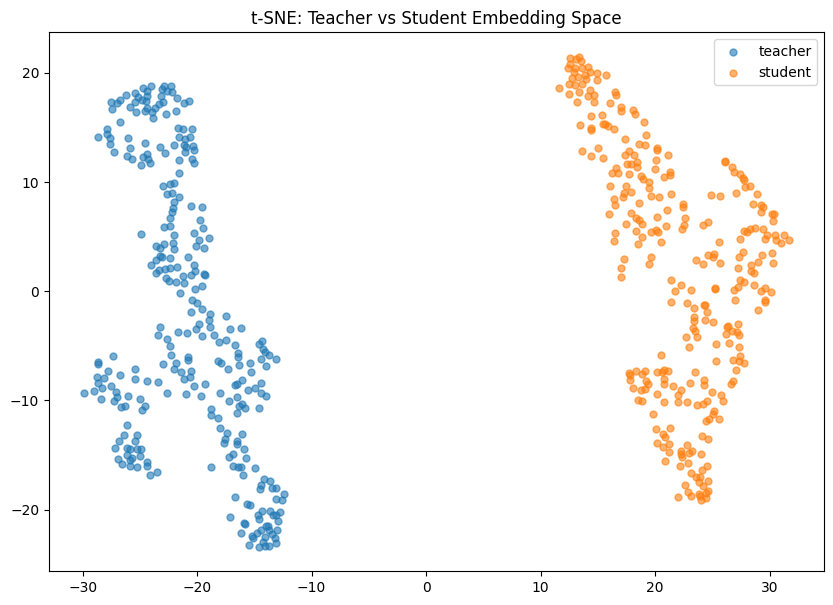

In [37]:
# =========================================================
# t-SNE Visualization of Teacher vs Student Embeddings
# =========================================================
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import torch
from tqdm import tqdm

# Take a small subset for visualization (e.g., 300 examples)
subset = ds["test"].select(range(300))
texts = subset["Data"]
labels = subset["Label"]

def get_embeddings(model, tokenizer, texts, max_len=128):
    model.eval()
    all_embeds = []
    for i in tqdm(range(0, len(texts), 16), desc="Embedding..."):
        batch_texts = texts[i:i+16]
        enc = tokenizer(batch_texts, padding=True, truncation=True,
                        max_length=max_len, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**enc, output_hidden_states=True)
            # CLS token embedding (last layer)
            embeds = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
        all_embeds.append(embeds)
    return np.vstack(all_embeds)

# Get embeddings from teacher & student
teacher_emb = get_embeddings(t_model, t_tokenizer, texts)
student_emb = get_embeddings(s_model, s_tokenizer, texts)

# Combine and reduce using t-SNE
combined_emb = np.vstack([teacher_emb, student_emb])
domain_labels = np.array(["teacher"] * len(teacher_emb) + ["student"] * len(student_emb))

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_emb = tsne.fit_transform(combined_emb)

# Plot
plt.figure(figsize=(10, 7))
for domain, color in zip(["teacher", "student"], ["#1f77b4", "#ff7f0e"]):
    mask = domain_labels == domain
    plt.scatter(tsne_emb[mask, 0], tsne_emb[mask, 1], label=domain, alpha=0.6, s=25, c=color)
plt.legend()
plt.title("t-SNE: Teacher vs Student Embedding Space")
plt.show()


# Cosine Similarity Analysis

Mean cosine similarity: 0.3430


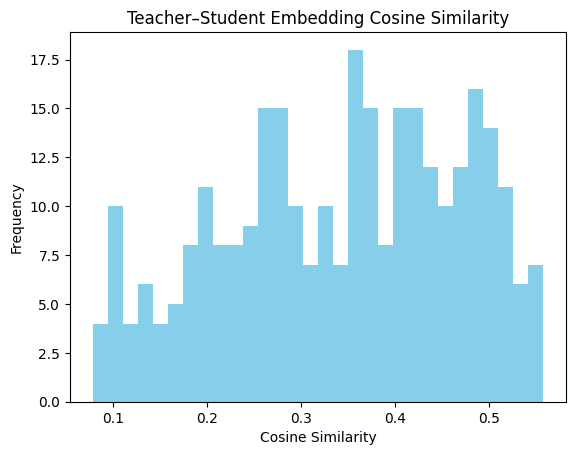

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

sim_scores = []
for i in range(len(teacher_emb)):
    sim = cosine_similarity(teacher_emb[i].reshape(1,-1), student_emb[i].reshape(1,-1))[0][0]
    sim_scores.append(sim)

print(f"Mean cosine similarity: {np.mean(sim_scores):.4f}")
plt.hist(sim_scores, bins=30, color='skyblue')
plt.title("Teacher–Student Embedding Cosine Similarity")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()


🔍 Generating predictions...


,Class,Teacher_F1,Student_F1,Diff
0,neutral,0.395,0.366,-0.029
1,positive,0.761,0.706,-0.054
2,negative,0.761,0.686,-0.074


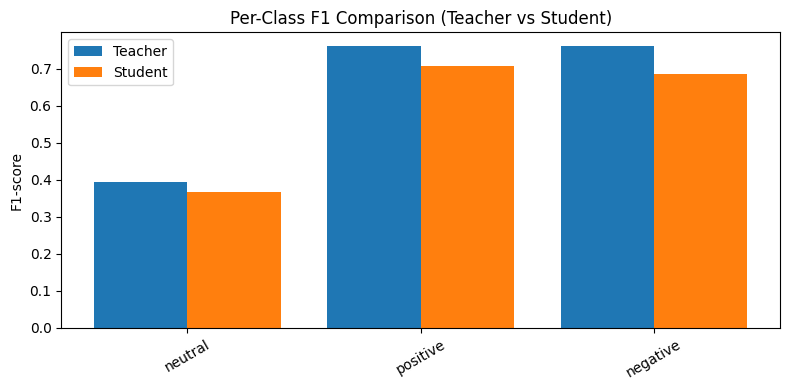

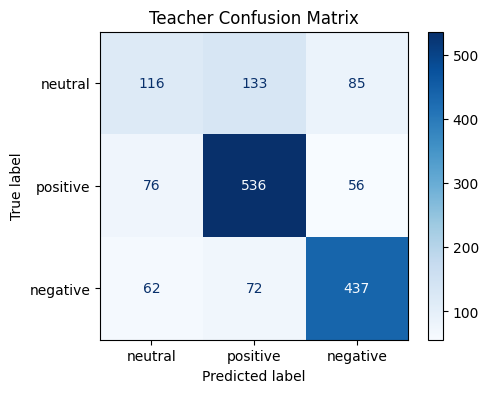

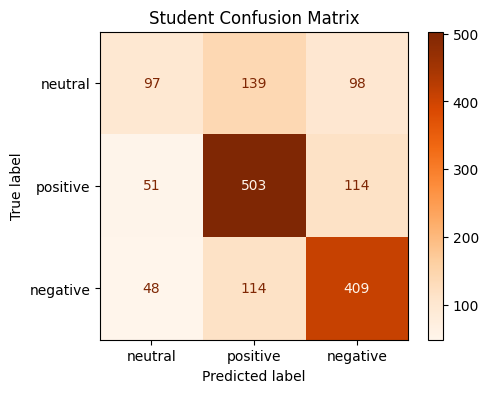

In [41]:
# =========================================================
# Per-Class F1 Comparison + Confusion Matrices (Teacher vs Student)
# =========================================================
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import DataCollatorWithPadding
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# -------------------------------
# Helper: Get predictions safely (ignores teacher_logits)
# -------------------------------
def get_preds(model, tokenizer, dataset, max_len=CFG["max_len"]):
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=DataCollatorWithPadding(tokenizer),
    )
    preds, labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            lbl = batch["labels"]
            # 🔧 Drop non-model keys
            batch = {k: v.to(device) for k, v in batch.items() if k not in ["labels", "teacher_logits"]}
            logits = model(**batch).logits
            preds.extend(logits.argmax(-1).cpu().tolist())
            labels.extend(lbl.tolist())
    return np.array(preds), np.array(labels)

# -------------------------------
# Get predictions for teacher & student
# -------------------------------
print("🔍 Generating predictions...")
t_preds, y_true = get_preds(t_model, t_tokenizer, t_ds["test"])
s_preds, _ = get_preds(s_model, s_tokenizer, s_ds["test"])

# -------------------------------
# Compute per-class F1-scores
# -------------------------------
target_names = [id2label[i] for i in range(CFG["num_labels"])]

t_report = classification_report(y_true, t_preds, target_names=target_names, output_dict=True)
s_report = classification_report(y_true, s_preds, target_names=target_names, output_dict=True)

df_f1 = pd.DataFrame({
    "Class": target_names,
    "Teacher_F1": [t_report[c]["f1-score"] for c in target_names],
    "Student_F1": [s_report[c]["f1-score"] for c in target_names],
})
df_f1["Diff"] = df_f1["Student_F1"] - df_f1["Teacher_F1"]
display(df_f1.round(3))

# -------------------------------
# Bar plot: per-class F1
# -------------------------------
plt.figure(figsize=(8,4))
x = np.arange(len(df_f1))
plt.bar(x-0.2, df_f1["Teacher_F1"], 0.4, label="Teacher")
plt.bar(x+0.2, df_f1["Student_F1"], 0.4, label="Student")
plt.xticks(x, df_f1["Class"], rotation=30)
plt.ylabel("F1-score")
plt.title("Per-Class F1 Comparison (Teacher vs Student)")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------------------
# Confusion Matrices
# -------------------------------
cm_t = confusion_matrix(y_true, t_preds, labels=list(range(len(target_names))))
cm_s = confusion_matrix(y_true, s_preds, labels=list(range(len(target_names))))

disp_t = ConfusionMatrixDisplay(confusion_matrix=cm_t, display_labels=target_names)
disp_s = ConfusionMatrixDisplay(confusion_matrix=cm_s, display_labels=target_names)

plt.figure(figsize=(5,4))
disp_t.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Teacher Confusion Matrix")
plt.show()

plt.figure(figsize=(5,4))
disp_s.plot(cmap="Oranges", values_format="d", ax=plt.gca())
plt.title("Student Confusion Matrix")
plt.show()


# Ablation Study — α (alpha) and Temperature Sweep

In [ ]:
# =========================================================
# Ablation: α (alpha) and Temperature Sweep
# =========================================================
import pandas as pd

alphas = [0.5, 0.7, 0.8, 0.9]
temps  = [2.0, 3.0, 4.0, 5.0]
results = []

for a in alphas:
    for t in temps:
        print(f"\n=== Running KD: α={a}, T={t} ===")
        kd_trainer = KDTrainer(
            model=s_model,
            args=s_args,
            train_dataset=s_ds["train"],
            eval_dataset=s_ds["validation"],
            tokenizer=s_tokenizer,
            data_collator=kd_collator,
            compute_metrics=compute_metrics,
            alpha=a,
            temperature=t,
        )
        kd_trainer.train()
        metrics = kd_trainer.evaluate(s_ds["test"])
        metrics["alpha"], metrics["temperature"] = a, t
        results.append(metrics)

# Save and visualize results
df = pd.DataFrame(results)
display(df[["alpha", "temperature", "eval_accuracy", "eval_f1_macro"]])

plt.figure(figsize=(8, 5))
for a in alphas:
    subset = df[df["alpha"] == a]
    plt.plot(subset["temperature"], subset["eval_f1_macro"], marker="o", label=f"α={a}")
plt.xlabel("Temperature")
plt.ylabel("F1 (macro)")
plt.title("Ablation: α and Temperature vs F1")
plt.legend()
plt.grid(True)
plt.show()



=== Running KD: α=0.5, T=2.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.5 T=2.0 loss_ce=0.7823 loss_kd=0.4244
[KD] step=0 α=0.5 T=2.0 loss_ce=0.9872 loss_kd=0.6876


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.644000,0.707732,0.598856,0.549482
2,0.584400,0.660616,0.610935,0.563163
3,0.526000,0.686096,0.617292,0.554279
4,0.489700,0.692353,0.630006,0.564276
5,0.474100,0.669437,0.626828,0.574414
6,0.464900,0.657918,0.631914,0.573988


[KD] step=100 α=0.5 T=2.0 loss_ce=0.8512 loss_kd=0.4506
[KD] step=100 α=0.5 T=2.0 loss_ce=0.7593 loss_kd=0.4204


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.5 T=2.0 loss_ce=0.9557 loss_kd=0.5614
[KD] step=200 α=0.5 T=2.0 loss_ce=0.7955 loss_kd=0.5041
[KD] step=300 α=0.5 T=2.0 loss_ce=0.8514 loss_kd=0.4941
[KD] step=300 α=0.5 T=2.0 loss_ce=0.9156 loss_kd=0.3774


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.5 T=2.0 loss_ce=0.8083 loss_kd=0.3481
[KD] step=400 α=0.5 T=2.0 loss_ce=0.4648 loss_kd=0.3116
[KD] step=500 α=0.5 T=2.0 loss_ce=0.6171 loss_kd=0.2441
[KD] step=500 α=0.5 T=2.0 loss_ce=0.5423 loss_kd=0.1966


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.5 T=2.0 loss_ce=0.5294 loss_kd=0.2776
[KD] step=600 α=0.5 T=2.0 loss_ce=0.4445 loss_kd=0.1792
[KD] step=700 α=0.5 T=2.0 loss_ce=0.7410 loss_kd=0.2463
[KD] step=700 α=0.5 T=2.0 loss_ce=0.6846 loss_kd=0.3260


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.5 T=2.0 loss_ce=0.7705 loss_kd=0.2449
[KD] step=800 α=0.5 T=2.0 loss_ce=0.7516 loss_kd=0.2944
[KD] step=900 α=0.5 T=2.0 loss_ce=0.8372 loss_kd=0.4181
[KD] step=900 α=0.5 T=2.0 loss_ce=0.5898 loss_kd=0.3134


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.5 T=2.0 loss_ce=0.8129 loss_kd=0.3354
[KD] step=1000 α=0.5 T=2.0 loss_ce=0.8209 loss_kd=0.2620
[KD] step=1100 α=0.5 T=2.0 loss_ce=0.5490 loss_kd=0.3282
[KD] step=1100 α=0.5 T=2.0 loss_ce=0.5562 loss_kd=0.2739


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.5, T=3.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.5 T=3.0 loss_ce=0.4717 loss_kd=0.2471
[KD] step=0 α=0.5 T=3.0 loss_ce=0.4284 loss_kd=0.2020


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.462500,0.681064,0.617928,0.584170
2,0.417800,0.820411,0.607756,0.551360
3,0.388900,0.728666,0.626828,0.568299
4,0.363000,0.722550,0.645264,0.597266
5,0.376100,0.724215,0.645264,0.594579
6,0.431000,0.684193,0.647171,0.596290


[KD] step=100 α=0.5 T=3.0 loss_ce=0.5562 loss_kd=0.2845
[KD] step=100 α=0.5 T=3.0 loss_ce=0.5667 loss_kd=0.3235


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.5 T=3.0 loss_ce=0.6643 loss_kd=0.3414
[KD] step=200 α=0.5 T=3.0 loss_ce=0.6185 loss_kd=0.3987
[KD] step=300 α=0.5 T=3.0 loss_ce=0.6430 loss_kd=0.2940
[KD] step=300 α=0.5 T=3.0 loss_ce=0.8970 loss_kd=0.3727


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.5 T=3.0 loss_ce=0.5858 loss_kd=0.3333
[KD] step=400 α=0.5 T=3.0 loss_ce=0.2429 loss_kd=0.0937
[KD] step=500 α=0.5 T=3.0 loss_ce=0.4937 loss_kd=0.2442
[KD] step=500 α=0.5 T=3.0 loss_ce=0.5084 loss_kd=0.2449


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.5 T=3.0 loss_ce=0.3680 loss_kd=0.1970
[KD] step=600 α=0.5 T=3.0 loss_ce=0.3267 loss_kd=0.1425
[KD] step=700 α=0.5 T=3.0 loss_ce=0.5197 loss_kd=0.1444
[KD] step=700 α=0.5 T=3.0 loss_ce=0.5005 loss_kd=0.2494


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.5 T=3.0 loss_ce=0.5835 loss_kd=0.1976
[KD] step=800 α=0.5 T=3.0 loss_ce=0.5647 loss_kd=0.2736
[KD] step=900 α=0.5 T=3.0 loss_ce=0.7279 loss_kd=0.3480
[KD] step=900 α=0.5 T=3.0 loss_ce=0.4235 loss_kd=0.2043


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.5 T=3.0 loss_ce=0.6125 loss_kd=0.2242
[KD] step=1000 α=0.5 T=3.0 loss_ce=0.7324 loss_kd=0.2889
[KD] step=1100 α=0.5 T=3.0 loss_ce=0.5051 loss_kd=0.3348
[KD] step=1100 α=0.5 T=3.0 loss_ce=0.5277 loss_kd=0.2634


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.5, T=4.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.5 T=4.0 loss_ce=0.4441 loss_kd=0.2869
[KD] step=0 α=0.5 T=4.0 loss_ce=0.4099 loss_kd=0.1352


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.402200,0.737050,0.633821,0.595149
2,0.349900,0.798587,0.640814,0.572166
3,0.338000,0.760344,0.632549,0.587600
4,0.320700,0.753069,0.639542,0.596032
5,0.369200,0.711441,0.642085,0.599525
6,0.408800,0.694848,0.652257,0.605538


[KD] step=100 α=0.5 T=4.0 loss_ce=0.4460 loss_kd=0.2534
[KD] step=100 α=0.5 T=4.0 loss_ce=0.3857 loss_kd=0.2013


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.5 T=4.0 loss_ce=0.5464 loss_kd=0.2944
[KD] step=200 α=0.5 T=4.0 loss_ce=0.5644 loss_kd=0.4137
[KD] step=300 α=0.5 T=4.0 loss_ce=0.5809 loss_kd=0.1921
[KD] step=300 α=0.5 T=4.0 loss_ce=0.6388 loss_kd=0.2706


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=400 α=0.5 T=4.0 loss_ce=0.5095 loss_kd=0.1830
[KD] step=400 α=0.5 T=4.0 loss_ce=0.2659 loss_kd=0.1994
[KD] step=500 α=0.5 T=4.0 loss_ce=0.3192 loss_kd=0.1473
[KD] step=500 α=0.5 T=4.0 loss_ce=0.3390 loss_kd=0.1549


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=600 α=0.5 T=4.0 loss_ce=0.2915 loss_kd=0.3191
[KD] step=600 α=0.5 T=4.0 loss_ce=0.2780 loss_kd=0.0910
[KD] step=700 α=0.5 T=4.0 loss_ce=0.2981 loss_kd=0.2360
[KD] step=700 α=0.5 T=4.0 loss_ce=0.4580 loss_kd=0.3967


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=800 α=0.5 T=4.0 loss_ce=0.5778 loss_kd=0.2016
[KD] step=800 α=0.5 T=4.0 loss_ce=0.6040 loss_kd=0.3594
[KD] step=900 α=0.5 T=4.0 loss_ce=0.6617 loss_kd=0.3641
[KD] step=900 α=0.5 T=4.0 loss_ce=0.4408 loss_kd=0.2579


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=1000 α=0.5 T=4.0 loss_ce=0.6663 loss_kd=0.2646
[KD] step=1000 α=0.5 T=4.0 loss_ce=0.6684 loss_kd=0.2891
[KD] step=1100 α=0.5 T=4.0 loss_ce=0.3687 loss_kd=0.2631
[KD] step=1100 α=0.5 T=4.0 loss_ce=0.5064 loss_kd=0.2071


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Running KD: α=0.5, T=5.0 ===


/tmp/ipykernel_37/1302430746.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `KDTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=0 α=0.5 T=5.0 loss_ce=0.3613 loss_kd=0.3139
[KD] step=0 α=0.5 T=5.0 loss_ce=0.2930 loss_kd=0.2626


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.322900,0.731627,0.624921,0.602732


[KD] step=100 α=0.5 T=5.0 loss_ce=0.3152 loss_kd=0.2051
[KD] step=100 α=0.5 T=5.0 loss_ce=0.3779 loss_kd=0.2287


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[KD] step=200 α=0.5 T=5.0 loss_ce=0.4195 loss_kd=0.1754
[KD] step=200 α=0.5 T=5.0 loss_ce=0.3633 loss_kd=0.3536
